In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.models.mlp import MLPScoreModel
from score_models.trainer import trainer
from score_models.train_steps import TrainStepDenoisingScoreMatching
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas

%load_ext autoreload
%autoreload 2



In [2]:
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
input_size = 2
hidden_size = 32
L = 10
lr = 5e-4

sigma_min = 1.0
sigma_max = 20.0

device = "cuda"

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, L=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=5e-4)

# define train step (i.e., criterion)
sigmas = get_sigmas(L=10, sigma_min=1.0, sigma_max=20.0)
train_step = TrainStepDenoisingScoreMatching(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_epochs=50
)

Step 0, Loss: 47.9226
Step 100, Loss: 0.9300
Step 200, Loss: 0.6836
Step 300, Loss: 0.5939
Step 400, Loss: 0.4796
Step 500, Loss: 0.4772
Step 600, Loss: 0.4565
Step 700, Loss: 0.4025
Step 800, Loss: 0.4036
Step 900, Loss: 0.3985
Step 1000, Loss: 0.3510
Step 1100, Loss: 0.3735
Step 1200, Loss: 0.3238
Step 1300, Loss: 0.3259
Step 1400, Loss: 0.3199
Step 1500, Loss: 0.4860
Step 1600, Loss: 0.3175
Step 1700, Loss: 0.3196
Step 1800, Loss: 0.2971
Step 1900, Loss: 0.3066
Step 2000, Loss: 0.3033
Step 2100, Loss: 0.3016
Step 2200, Loss: 0.2961
Step 2300, Loss: 0.3045
Step 2400, Loss: 0.2940
Step 2500, Loss: 0.2918
Step 2600, Loss: 0.2998
Step 2700, Loss: 0.2813
Step 2800, Loss: 0.2847
Step 2900, Loss: 0.2632
Step 3000, Loss: 0.2525
Step 3100, Loss: 0.2489
Step 3200, Loss: 0.2709
Step 3300, Loss: 0.2809
Step 3400, Loss: 0.2788
Step 3500, Loss: 0.2615
Step 3600, Loss: 0.2970
Step 3700, Loss: 0.2712
Step 3800, Loss: 0.2920
Step 3900, Loss: 0.2759


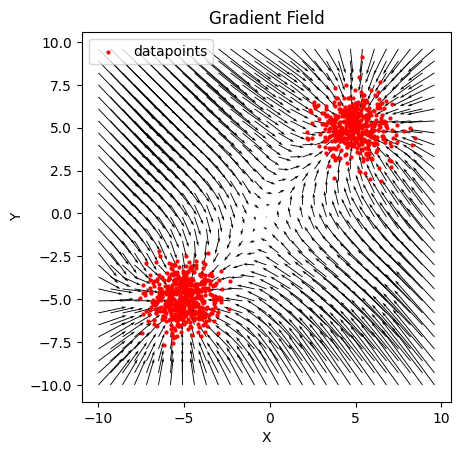

In [5]:
from score_models.utils.visualisations import plot_gradient_field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000])

In [6]:
import numpy as np
from tqdm import tqdm
from score_models.sampling import annealed_langevin_dynamics

samples = np.concatenate(
    [
        annealed_langevin_dynamics(score_model=score_model, input_size=(2, ), sigmas=sigmas,).cpu()
        for _ in tqdm(range(500))
    ],
    axis=0
)

100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


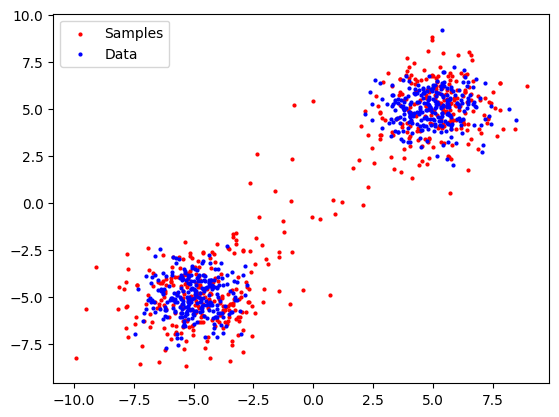

In [7]:
import matplotlib.pyplot as plt

ax = plt.gca()
ax.scatter(
    samples[:, 0], samples[:, 1], color='red', s=4, label='Samples'
)
ax.scatter(
    dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data'
)
plt.legend();